In [31]:
import os
import pandas as pd
import json
import numpy as np
from collections import OrderedDict
from data.load import load_dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import matplotlib as mpl

stat_file_name = 'df_metrics.csv'
MEAS_PATH = 'results/13th_run/'
DATA_PATH = '/media/balint/Backup1/data/1d-class-datasets/interpolated-7th-run/'
TIMES = [30, 60, 90, 120, 150] # sorted(os.listdir(MEAS_PATH))
MEAS_TYPES = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]
NETWORKS = [f for f in os.listdir(os.path.join(MEAS_PATH, MEAS_TYPES[0], str(TIMES[0]))) if os.path.isdir(os.path.join(MEAS_PATH, MEAS_TYPES[0], str(TIMES[0]), f))]
VAL_FOLDERS = sorted([ n for n in os.listdir(os.path.join(MEAS_PATH, MEAS_TYPES[0], str(TIMES[0]), NETWORKS[0])) if 'cv' in n])
DATA_FOLDERS = sorted([os.path.join(DATA_PATH, t) for t in MEAS_TYPES])


# cm = cmap.get_cmap('Set1', 7)
cm = ['#32CD32','#00bfff', '#ff0000','#FFA500','#9932cc','#964B00','#808080']
model_names = {
    'cnn': 'CNN',
    'mlp': 'MLP',
    'mcdcnn': 'MCDCNN',
    'fcn': 'FCN',
    'resnet': 'ResNet',
    'inception': 'Inception'
}

cell_types = {
    'preo':'MC3T3-E1',
    'hela':'HeLa',
    'mcf7':'MCF-7',
    'mdamb231':'MDA MB 231',
    'lclc':'LCLC-103H',
    'breastcancer':'Breast cancer'
}

def format_cell_types(st):
    selected_types = sorted([ cell_types[tp] for tp in st.split('-')])
    return ' | '.join(selected_types)

In [37]:
cell_counts = {}
for tp in MEAS_TYPES:
    # cnts = []
    types = { cell_types[t]: [] for t in tp.split('-')}
    for time in TIMES:
        pth = os.path.join(DATA_PATH, tp,str(time))
        if os.path.exists(pth):
            counts = {}
            X_train, y_train, X_test, y_test, (names, tags), scaler = load_dataset(pth, False, False)
            data = np.vstack([X_train, X_test])
            labels = np.concatenate([y_train, y_test])
            el, cnt = np.unique(labels, return_counts=True)
            for n, l in zip(names, tags):
                counts[n] = cnt[l]
                types[cell_types[n]].append(str(cnt[l]))
    cell_counts[format_cell_types(tp)] = { cell_types[t]: '|'.join(types[cell_types[t]]) for t in tp.split('-')}

with open(os.path.join(DATA_PATH, 'cell_counts.json'), 'w') as fp:
    json.dump(cell_counts, 
              fp, 
              sort_keys=False,
              indent=4,
              separators=(',', ': ')
              )
cell_counts

{'HeLa | MCF-7 | MDA MB 231': {'HeLa': '909|909|909|909|909',
  'MCF-7': '1000|1000|1000|349|349',
  'MDA MB 231': '1466|1466|1466|1466|1466'},
 'HeLa | LCLC-103H | MC3T3-E1 | MCF-7 | MDA MB 231': {'HeLa': '909|909|909|909|909',
  'LCLC-103H': '376|376|376|376|376',
  'MCF-7': '1000|1000|1000|349|349',
  'MDA MB 231': '1466|1466|1466|1466|1466',
  'MC3T3-E1': '767|767|767|767|767'},
 'MCF-7 | MDA MB 231': {'MCF-7': '1000|1000|1000|349|349',
  'MDA MB 231': '1466|1466|1466|1466|1466'},
 'HeLa | LCLC-103H | MCF-7 | MDA MB 231': {'HeLa': '909|909|909|909|909',
  'LCLC-103H': '376|376|376|376|376',
  'MCF-7': '1000|1000|1000|349|349',
  'MDA MB 231': '1466|1466|1466|1466|1466'},
 'Breast cancer | HeLa | LCLC-103H': {'Breast cancer': '2466|2466|2466|1815|1815',
  'HeLa': '909|909|909|909|909',
  'LCLC-103H': '376|376|376|376|376'},
 'Breast cancer | HeLa | LCLC-103H | MC3T3-E1': {'Breast cancer': '2466|2466|2466|1815|1815',
  'HeLa': '909|909|909|909|909',
  'LCLC-103H': '376|376|376|376|37

In [38]:
stats_dict = {}

for tp in MEAS_TYPES:
    if not tp in stats_dict:
        stats_dict[tp] = {}
    for nw in NETWORKS:
        if not nw in stats_dict[tp]:
            stats_dict[tp][nw] = {}
        for tm in TIMES:    
            precision, accuracy, recall, duration = [], [], [], []
            for fd in VAL_FOLDERS:
                df = pd.read_csv(os.path.join(MEAS_PATH, tp, str(tm), nw, fd, stat_file_name))
                precision.append(df.precision.item())
                accuracy.append(df.accuracy.item())
                recall.append(df.recall.item())
                duration.append(df.duration.item())
            stats_dict[tp][nw][tm] = {
                'precision': [np.round(np.mean(precision), 2), np.round(np.std(precision), 2), np.round(np.max(precision), 2)],
                'accuracy': [np.round(np.mean(accuracy), 2), np.round(np.std(accuracy), 2), np.round(np.max(accuracy), 2)],
                'recall': [np.round(np.mean(recall), 2), np.round(np.std(recall), 2), np.round(np.max(recall), 2)],
                'duration': [np.round(np.mean(duration), 2), np.round(np.std(duration), 2), np.round(np.max(duration), 2)]
            }
                    
                
                    
with open(os.path.join(MEAS_PATH, 'stats.json'), 'w') as fp:
    json.dump(stats_dict, 
              fp, 
              sort_keys=False,
              indent=4,
              separators=(',', ': ')
              )

In [40]:
stats_dict = {}
for nw in NETWORKS:
    if not nw in stats_dict:
        stats_dict[nw] = {}
    for tp in MEAS_TYPES:
        if not tp in stats_dict[nw]:
            stats_dict[nw][tp] = {}
        l = []
        for tm in TIMES:    
            precision, accuracy, recall, duration = [], [], [], []
            for fd in VAL_FOLDERS:
                df = pd.read_csv(os.path.join(MEAS_PATH, tp, str(tm), nw, fd, stat_file_name))
                precision.append(df.precision.item())
                accuracy.append(df.accuracy.item())
                recall.append(df.recall.item())
                duration.append(df.duration.item())
            stats_dict[nw][tp][tm] = {
                # 'precision': [np.round(np.mean(precision), 2), np.round(np.std(precision), 2), np.round(np.max(precision), 2)],
                'accuracy': [np.round(np.mean(accuracy), 2), np.round(np.std(accuracy), 2), np.round(np.max(accuracy), 2)],
                # 'recall': [np.round(np.mean(recall), 2), np.round(np.std(recall), 2), np.round(np.max(recall), 2)],
                # 'duration': [np.round(np.mean(duration), 2), np.round(np.std(duration), 2), np.round(np.max(duration), 2)]
            }
            l.append([precision, accuracy, recall, duration])
        stats_dict[nw][tp] = [np.round(np.mean(e[1]), 2) for e in l]
        # {
        #     # 'precision': [[np.mean(e[0]), np.std(e[0]), np.max(e[0])] for e in l],
        #     'accuracy': [np.mean(e[1]) for e in l],
        #     # 'recall': [[np.mean(e[2]), np.std(e[2]), np.max(e[2])] for e in l],
        #     # 'duration': [[np.mean(e[3]), np.std(e[3]), np.max(e[3])] for e in l]
            
        #     # 'precision': np.mean([np.mean(e[0]) for e in l]),
        #     # 'accuracy': np.mean([np.mean(e[1]) for e in l]),
        #     # 'recall': np.mean([np.mean(e[2]) for e in l]),
        #     # # 'duration': np.mean([np.mean(e[3]) for e in l]),
        #     # 'best_time': TIMES[np.argmax([np.mean(e[1]) for e in l])]
        # }
                    
                
                    
# with open('stats.json', 'w') as fp:
#     json.dump(stats_dict, 
#               fp, 
#               sort_keys=False,
#               indent=4,
#               separators=(',', ': ')
#               )

/tmp/ipykernel_827049/4089445231.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[n//3, n%3].set_xticklabels([i*0.5 for i in range(6)])


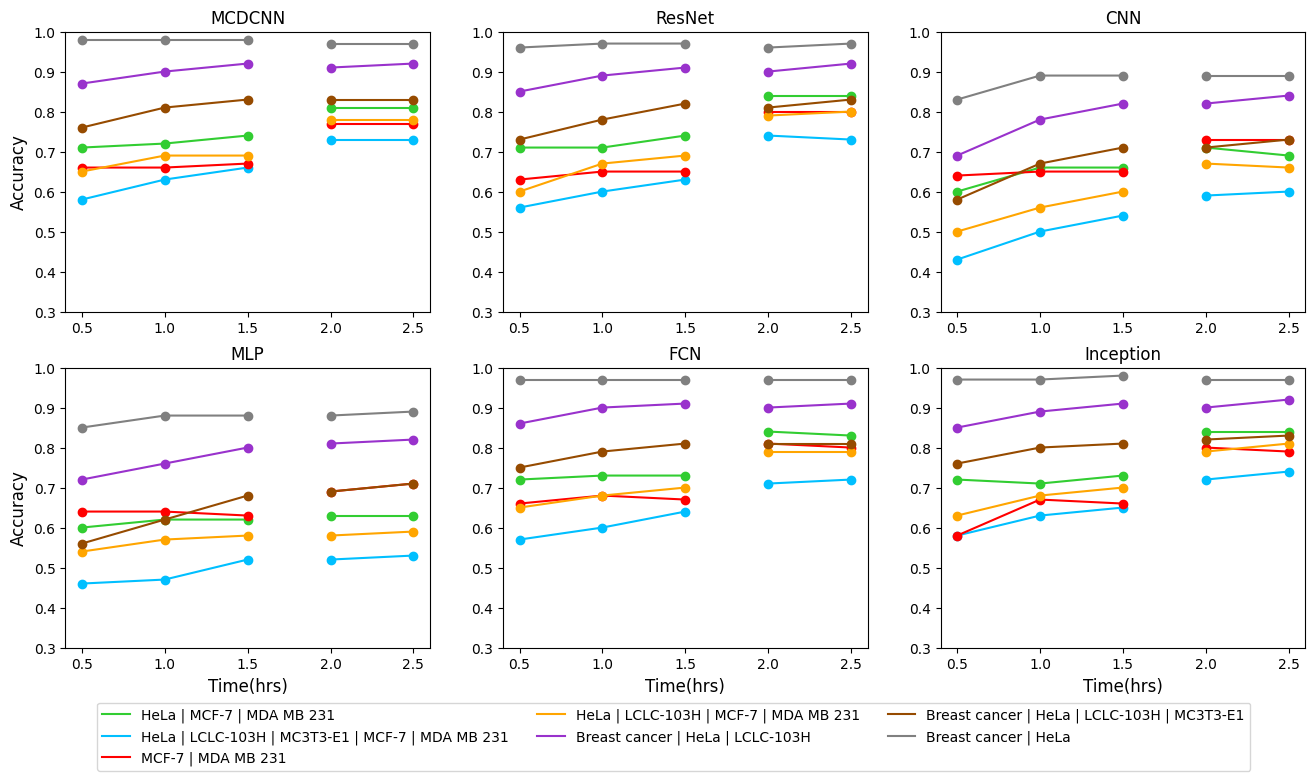

In [65]:
def group_indices_by_value(lst):
    index_list = [[] for _ in range(max(lst) + 1)]
    
    for i, item in enumerate(lst):
        index_list[item].append(i)
    
    return [indices for indices in index_list if indices]

def slice_list_with_indices(input_list, indices):
    return [input_list[i] for i in indices]

fig, ax = plt.subplots(2, 3, figsize=(16,8))

for n, (key, value) in enumerate(stats_dict.items()):
    for m, (m_key, m_value) in enumerate(value.items()):
        cnts = cell_counts[format_cell_types(m_key)]
        cnts = np.array([list(map(int, o.split('|'))) for o in list(cnts.values())])
        indices = group_indices_by_value(list(np.sum(cnts, axis=0)))
        indices.reverse()
        pos = 0
        for i, lst in enumerate(indices):
            slc = slice_list_with_indices(m_value, lst)
            ax[n//3, n%3].plot([pos + i for i in range(len(slc))], slc, c=cm[m], label=format_cell_types(m_key) if n == 0 and i == 0 else None)
            pos += len(slc)
        ax[n//3, n%3].plot(m_value, 'o', c=cm[m])
        
    ax[n//3, n%3].set_title(model_names[key],fontsize=12)
    ax[n//3, n%3].set_ylim((0.3, 1))
    ax[n//3, n%3].set_xticklabels([i*0.5 for i in range(6)])
    if n > 2:
        ax[n//3, n%3].set_xlabel("Time(hrs)",fontsize=12)
    if n == 0 or n == 3:
        ax[n//3, n%3].set_ylabel("Accuracy",fontsize=12)
    if n == 0:
        ax[n//3, n%3].legend(ncol=3, bbox_to_anchor=(0.87, 0.05),
                bbox_transform=fig.transFigure)
plt.savefig(os.path.join(MEAS_PATH, 'network-compare.jpg'), dpi=300)

In [ ]:
networks = ['resnet', 'inception', 'mcdcnn']
stats_dict = {}
for nw in networks:
    if not nw in stats_dict:
        stats_dict[nw] = {}
    for tp in MEAS_TYPES:
        if not tp in stats_dict[nw]:
            stats_dict[nw][tp] = {}
        l = []
        for tm in ['1hrs']:    
            precision, accuracy, recall, duration = [], [], [], []
            for fd in VAL_FOLDERS:
                df = pd.read_csv(os.path.join(MEAS_PATH, tm, tp, nw, 'train-test_itr_0', fd, stat_file_name))
                precision.append(df.precision.item())
                accuracy.append(df.accuracy.item())
                recall.append(df.recall.item())
                duration.append(df.duration.item())
            stats_dict[nw][tp][tm] = {
                # 'precision': [np.round(np.mean(precision), 2), np.round(np.std(precision), 2), np.round(np.max(precision), 2)],
                'accuracy': [np.round(np.mean(accuracy), 2), np.round(np.std(accuracy), 2), np.round(np.max(accuracy), 2)],
                # 'recall': [np.round(np.mean(recall), 2), np.round(np.std(recall), 2), np.round(np.max(recall), 2)],
                # 'duration': [np.round(np.mean(duration), 2), np.round(np.std(duration), 2), np.round(np.max(duration), 2)]
            }
            l.append([precision, accuracy, recall, duration])
        e = l[0]
        stats_dict[nw][tp] = {
                'precision': [np.round(np.mean(e[0]),2), np.round(np.std(e[0]),2)],
                'accuracy': [np.round(np.mean(e[1]),2), np.round(np.std(e[1]),2)],
                'recall': [np.round(np.mean(e[2]),2), np.round(np.std(e[2]),2)],
                # 'duration': [[np.mean(e[3]), np.std(e[3]), np.max(e[3])] for e in l]
            }
                    
                
                    
with open('stats.json', 'w') as fp:
    json.dump(stats_dict, 
              fp, 
              sort_keys=False,
              indent=4,
              separators=(',', ': ')
              )

In [35]:
stats_list = []

for tp in MEAS_TYPES:
    for nw in NETWORKS:
       row = [format_cell_types(tp), model_names[nw], stats_dict[nw][tp]['precision'],stats_dict[nw][tp]['accuracy'],stats_dict[nw][tp]['recall']] 
       stats_list.append(row)
       
df = pd.DataFrame(stats_list, columns=['setup', 'network', 'precision', 'accuracy', 'recall'])
df.to_excel('stats.xlsx')
df

TypeError: list indices must be integers or slices, not str

In [ ]:
names[nw]